<a href="https://colab.research.google.com/github/aivrm/ai/blob/main/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_Top_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 모델링으로 타이타닉 톱 4%

* 출처:

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling


In [222]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
* 1 소개

* 2 로드 하고 데이터 체크
        2.1 데이터 로드
        2.2 이상치 감지
        2.3 train 과 test 셋 합치기
        2.4 널과 없는(잘못된) 값 체크

* 3 특성 분석
        3.1 숫자 값
        3.2 범주 값

* 4 없는 값 채우기
        4.1 나이

* 5 특성 엔지니어링
        5.1 이름/타이틀
        5.2 가족 사이즈
        5.3 객실
        5.4 티켓

* 6 모델링
        6.1 단순 모델링
            6.1.1 상호 입증 모델
            6.1.2 최고의 모델을 위한 하이퍼파라미터 튜닝
            6.1.3 학습곡선 그리기
            6.1.4 트리 기반 분류기의 특성 중요도

        6.2 앙상블 모델
            6.2.1 결합 모델

        6.3 예측
            6.3.1 예측과 결과 제출
---


---
## 1. 소개

이것은 Kaggle의 첫 번째 커널입니다. 저는 피쳐 엔지니어링과 앙상블 모델링을 소개하는 좋은 방법인 타이타닉 대회를 선택했습니다. 먼저 몇 가지 기능 분석을 표시한 다음 기능 엔지니어링에 중점을 두지 않을 것입니다. 마지막 부분은 투표 절차를 사용하여 타이타닉호의 생존을 모델링하고 예측하는 것과 관련이 있습니다.

* 특성 분석
* 특성 엔지니어링
* 모델링
---

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

---
## 2. 데이터 로드 와 체크
---

### 2.1 데이터 로드

In [224]:
# Load data
##### Load train and Test set
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/_aiffel/titanic/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/_aiffel/titanic/data/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier 감지

In [225]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)

이상치는 예측에 극적인 영향을 미칠 수 있기 때문에(특히 회귀 문제의 경우) 나는 이상치를 관리하기로 선택했습니다.

나는 Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값(IQR)의 1사분위수와 3사분위수 사이로 구성된 사분위수 범위를 정의하는 ouliers를 감지했습니다. 이상치는 특성 값이 (IQR +- 이상치 단계) 외부에 있는 행입니다.

숫자 값 기능(Age, SibSp, Sarch 및 Fare)에서 이상값을 감지하기로 결정했습니다. 그런 다음 이상값을 2개 이상의 이상값이 있는 행으로 간주했습니다.

In [226]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


122 / 5,000
번역 결과
10개의 이상값을 감지합니다. 28, 89 및 342 승객은 높은 티켓 운임이 있습니다.

나머지 7개는 SibSP 값이 매우 높습니다.

In [227]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 훈련과 테스트 셋 합치기

In [228]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

범주형 변환 중에 동일한 수의 기능을 얻기 위해 데이터 세트를 훈련하고 테스트합니다(기능 엔지니어링 참조).

### 2.4 널 과 빈 값 검사

In [229]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age 및 Cabin 특성은 결측값의 중요한 부분을 차지합니다.

생존 누락 값은 조인 테스트 데이터 세트에 해당합니다(생존 열은 테스트 세트에 존재하지 않으며 기차와 테스트 세트를 연결할 때 NaN 값으로 대체되었습니다).

In [230]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [231]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [232]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [233]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


---
## 3. 특성 분석
---

### 3.1 숫자값

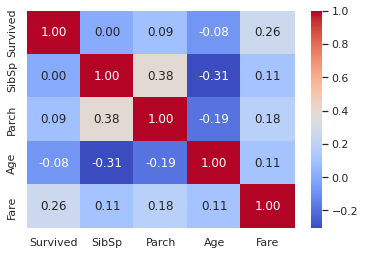

In [234]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

운임특성만이 생존확률과 유의한 상관관계가 있는 것으로 보인다.

다른 기능이 유용하지 않다는 의미는 아닙니다. 이러한 기능의 하위 개체군은 생존과 상관관계가 있을 수 있습니다. 이를 확인하려면 이러한 기능을 자세히 조사해야 합니다.

#### SibSP

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


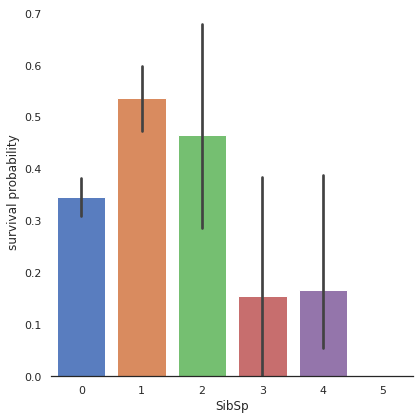

In [235]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제/배우자가 많은 승객은 생존 가능성이 낮아 보입니다.

1인 승객(0 SibSP) 또는 2명과 함께(SibSP 1 또는 2) 생존할 가능성이 더 높습니다.

이 관찰은 매우 흥미롭습니다. 이러한 범주를 설명하는 새로운 기능을 고려할 수 있습니다(기능 엔지니어링 참조)

#### Parch

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


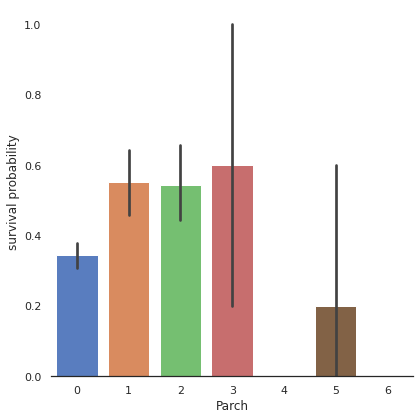

In [236]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

소가족은 싱글(Parch 0), 중형(Parch 3,4) 및 대가족(Parch 5,6)보다 더 많은 생존 기회가 있습니다.

부모/자녀가 3명인 승객의 생존에는 중요한 표준 편차가 있으므로 주의하십시오.

#### Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


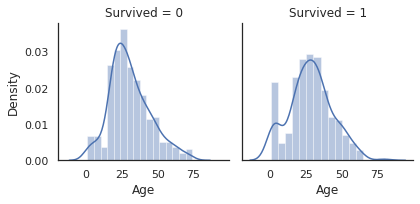

In [237]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

연령 분포는 꼬리가 있는 분포, 아마도 가우스 분포인 것 같습니다.

우리는 연령 분포가 생존한 하위 집단과 생존하지 않은 하위 집단에서 동일하지 않다는 것을 알 수 있습니다. 실제로 살아남은 젊은 승객에 해당하는 피크가 있습니다. 우리는 또한 60-80세 사이의 승객들이 덜 살아남았다는 것을 알 수 있습니다.

따라서 "나이"가 "생존"과 상관 관계가 없더라도 생존 가능성이 다소 있는 승객의 연령 범주가 있음을 알 수 있습니다.

아주 어린 승객이 생존할 가능성이 더 높은 것 같습니다.

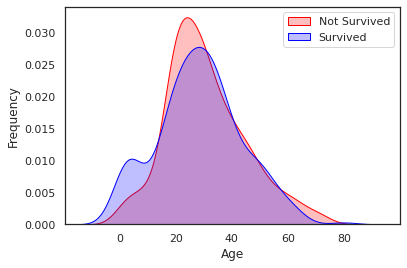

In [238]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

두 밀도를 중첩하면 아기와 아주 어린 아이들에게 해당하는 피크(0과 5 사이)가 명확하게 보입니다.

#### Fare

In [239]:
dataset["Fare"].isnull().sum()

1

In [240]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

하나의 누락된 값이 있으므로 예측에 중요한 영향을 미치지 않는 중앙값으로 채우기로 결정했습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


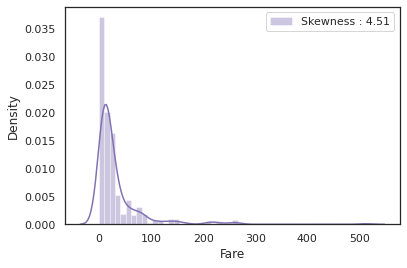

In [241]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

보시다시피 운임 분배는 매우 편향되어 있습니다. 이로 인해 크기가 조정된 경우에도 모델에서 매우 높은 값의 과체중이 발생할 수 있습니다.

이 경우 이 스큐를 줄이기 위해 로그 함수로 변환하는 것이 좋습니다.

In [242]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


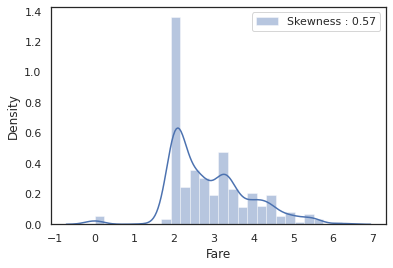

In [243]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

[위에 그림]
Skewness is clearly reduced after the log transformation

로그 변환 후 왜곡이 명확하게 감소합니다.

### 3.2 범주값

#### Sex

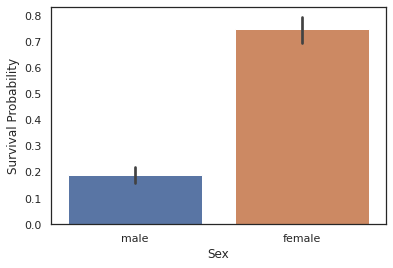

In [244]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [245]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존 가능성이 적다는 것은 분명합니다.

따라서 섹스는 생존 예측에 중요한 역할을 할 수 있습니다.

타이타닉 영화(1997)를 본 사람들은 대피 중 이 문장을 기억할 것입니다. "여성과 어린이 우선".

#### Pclass

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


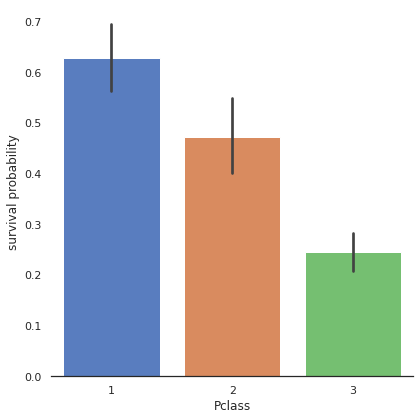

In [246]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


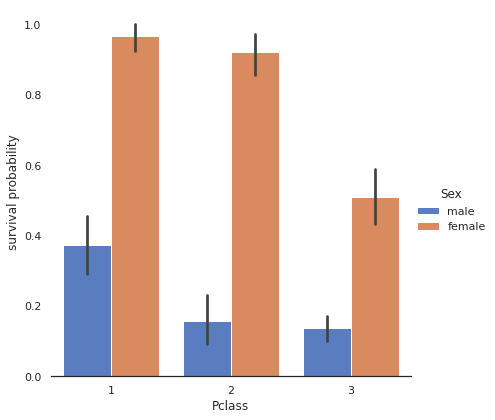

In [247]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

승객 생존은 3 클래스에서 동일하지 않습니다. 1등석 승객은 2등석 및 3등석 승객보다 생존 가능성이 더 높습니다.

이 경향은 남성과 여성 승객 모두를 볼 때 보존됩니다.

#### Embarked

In [248]:
dataset["Embarked"].isnull().sum()

2

In [249]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

두 개의 누락된 값이 있으므로 "Embarked"(S)의 가장 빈번한 값으로 채우기로 결정했습니다.


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


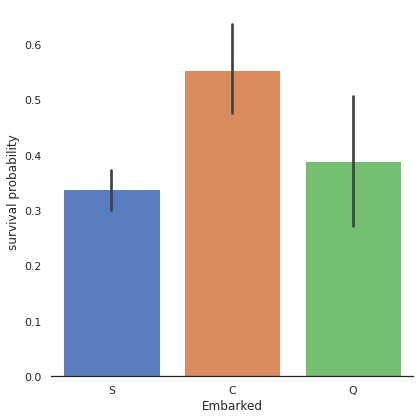

In [250]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

셰르부르(C)에서 오는 승객은 생존 가능성이 더 높아 보인다.

제 가설은 퀸스타운(Q), 사우샘프턴(S)보다 셰르부르에서 오는 사람들의 일등석 승객 비율이 더 높다는 것입니다.

Pclass 분포 대 Embarked를 봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


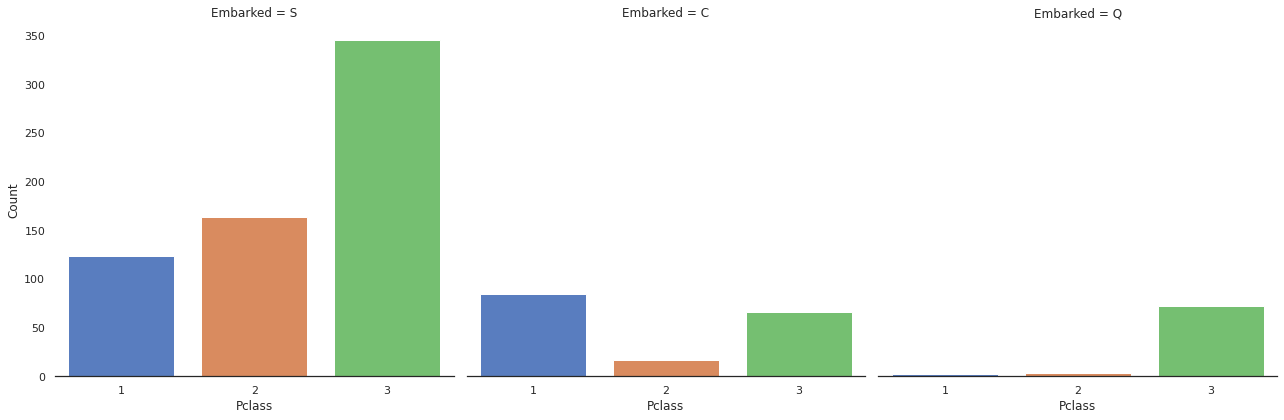

In [251]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

실제로 3등석은 Southampton(S)과 Queenstown(Q)에서 오는 승객에게 가장 빈번한 반면 Cherbourg 승객은 대부분 생존율이 가장 높은 1등석입니다.

지금 시점에서 퍼스트 클래스의 생존율이 높은 이유를 설명할 수 없습니다. 제 가설은 1등석 승객이 영향을 받아 대피 과정에서 우선 순위가 높다는 것입니다.

---
## 4. 빈 값 채우기
---

### 4.1 나이

보시다시피 Age 열에는 전체 데이터 세트에서 256개의 누락된 값이 있습니다.

생존 가능성이 더 높은 하위 모집단(예: 어린이)이 있으므로 연령 특성을 유지하고 결측값을 대치하는 것이 좋습니다.

이 문제를 해결하기 위해 연령과 가장 상관관계가 높은 기능(Sex, Parch, Pclass 및 SibSP)을 살펴보았습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

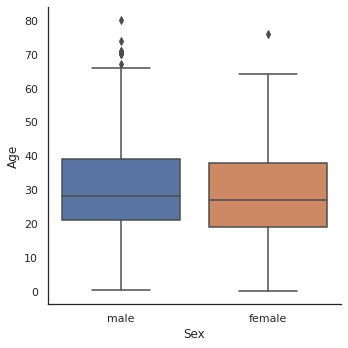

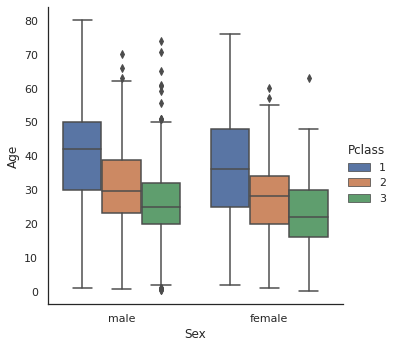

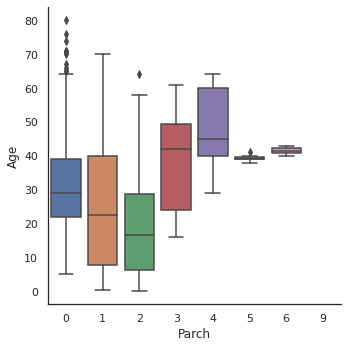

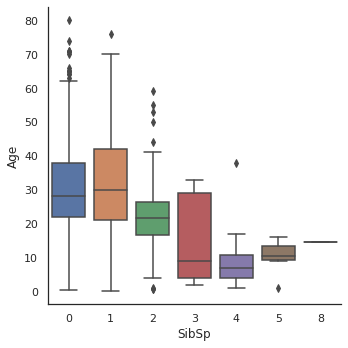

In [252]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

연령 분포는 남성과 여성 하위 모집단에서 동일한 것으로 보이므로 성별은 연령을 예측하는 데 유용하지 않습니다.

그러나 1등석 승객은 2등석 승객보다 나이가 많고 3등석 승객보다 나이가 많습니다.

더욱이, 승객이 나이가 많을수록 부모/자녀가 많을수록 승객은 더 어린 형제/배우자가 있습니다.

In [253]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

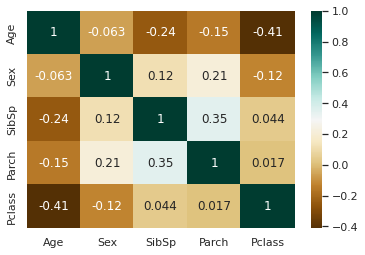

In [254]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

연령 분포는 남성 및 여성 하위 모집단에서 동일한 것으로 보이므로 성별은 정보가 아닙니다. 상관 지도는 Parch를 제외한 요인 그림 관찰을 확인합니다. 나이는 성별과 상관 관계가 없지만 Pclass, Parch 및 SibSp와 음의 상관 관계가 있습니다.

Parch의 기능에 따른 연령 플롯에서 연령은 부모/자녀의 수에 따라 증가합니다. 그러나 일반적인 상관관계는 음수입니다.

그래서 나는 누락된 연령을 추정하기 위해 SibSP, Parch 및 Pclass를 사용하기로 결정했습니다.

전략은 Age를 예측하기 위해 Pclass, Parch 및 SibSp.mative에 따라 유사한 행의 중앙값 연령으로 Age를 채우는 것입니다.

그러나 1등석 승객은 2등석 승객보다 나이가 많고 3등석 승객보다 나이가 많습니다.

더욱이, 승객이 나이가 많을수록 부모/자녀가 많을수록 승객은 더 어린 형제/배우자가 있습니다.

In [255]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning:
DataFrame의 슬라이스 복사본에 값을 설정하려고 합니다.

설명서의 주의 사항을 참조하세요. http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
   self._setitem_with_indexer(인덱서, 값)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


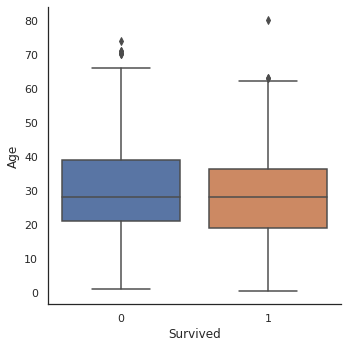

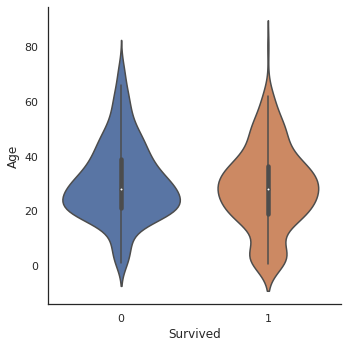

In [256]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

생존한 하위 집단과 생존하지 않은 하위 집단에서 연령의 중앙값 사이에는 차이가 없습니다.

그러나 생존한 승객의 바이올린 플롯에서 우리는 여전히 아주 어린 승객의 생존율이 더 높다는 것을 알 수 있습니다.

---
## 5. 특성 엔지니어링
---

### 5.1 이름/타이틀

In [257]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름 기능은 승객의 직위에 대한 정보를 포함합니다.

대피하는 동안 고유한 직함을 가진 일부 승객이 선호될 수 있으므로 모델에 추가하는 것이 흥미로울 것입니다.

In [258]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

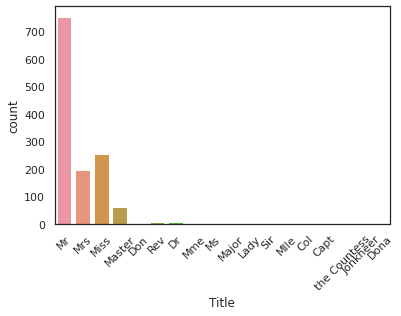

In [259]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

데이터 세트에는 17개의 제목이 있으며 대부분은 매우 드물며 4개의 범주로 그룹화할 수 있습니다.

In [260]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


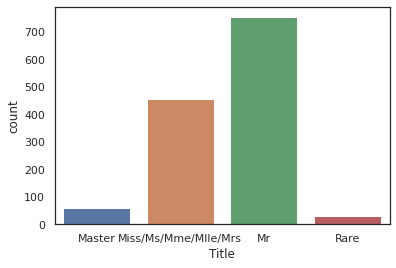

In [261]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


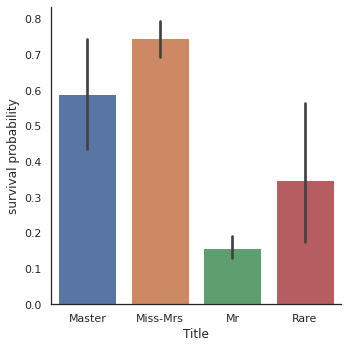

In [262]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [263]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

"여성과 어린이 우선"

희귀 칭호를 가진 승객이 생존할 확률이 더 높다는 점은 흥미롭습니다.

### 5.2 가족 사이즈

대가족은 대피하는 동안 자매/형제/부모를 찾아 대피하는 데 더 많은 어려움을 겪을 것이라고 상상할 수 있습니다. 그래서 SibSp , Parch 및 1(승객 포함)의 합계인 "Fize"(패밀리 크기) 기능을 만들기로 결정했습니다.

In [264]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


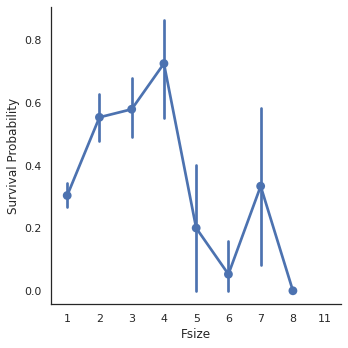

In [265]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

가족 규모가 중요한 역할을 하는 것으로 보이며, 대가족의 경우 생존 확률이 가장 낮습니다.

또한 가족 규모의 4가지 범주를 만들기로 결정했습니다.

In [266]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

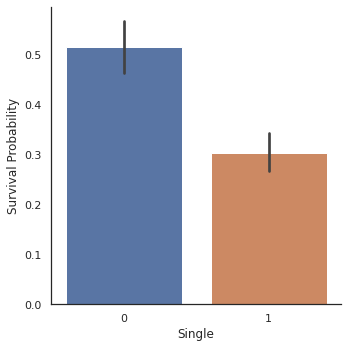

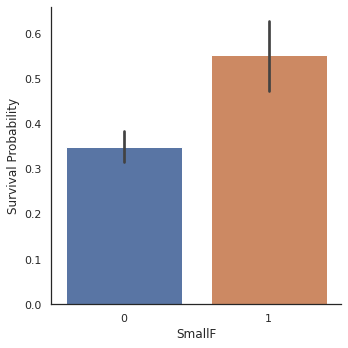

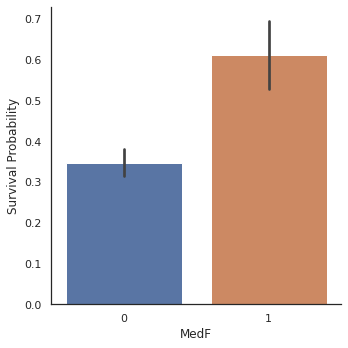

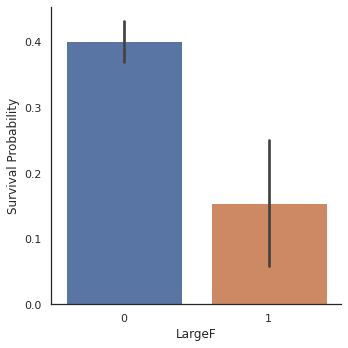

In [267]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

가족 규모가 중요한 역할을 하는 것으로 보이며, 대가족의 경우 생존 확률이 가장 낮습니다.

또한 가족 규모의 4가지 범주를 만들기로 결정했습니다.

In [268]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [269]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


이 단계에서는 22개의 기능이 있습니다.

### 5.3 객실

In [270]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [271]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [272]:
dataset["Cabin"].isnull().sum()

1007

Cabin 특성 열에는 292개의 값과 1007개의 결측값이 있습니다.

객실이 없는 승객은 객실 번호 대신 누락된 값이 표시된다고 가정했습니다.

In [273]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [274]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

객실의 첫 글자는 데스크를 나타내며 타이타닉에서 승객의 가능한 위치를 나타내기 때문에 이 정보만 유지하기로 했습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


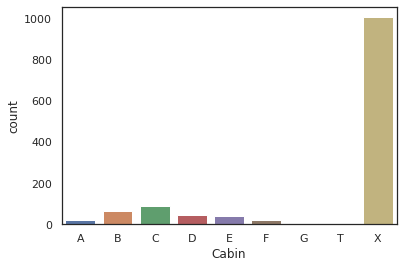

In [275]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


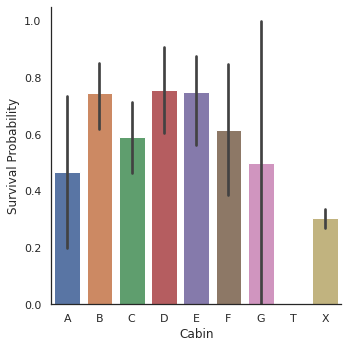

In [276]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

객실이 있는 승객의 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지며 다른 데스크에 있는 승객의 생존 확률을 구별할 수 없습니다.

그러나 캐빈이 있는 승객은 일반적으로 (X)가 없는 승객보다 생존 가능성이 더 높다는 것을 알 수 있습니다.

캐빈 B, C, D, E 및 F의 경우 특히 그렇습니다.

In [277]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 티켓

In [278]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

동일한 접두사를 공유하는 티켓이 함께 배치된 캐빈에 대해 예약될 수 있음을 의미할 수 있습니다. 따라서 선박 내 캐빈의 실제 배치로 이어질 수 있습니다.

접두어가 같은 티켓은 클래스와 생존이 비슷할 수 있습니다.

그래서 티켓 기능 열을 티켓 접두사로 바꾸기로 결정했습니다. 더 많은 정보를 얻을 수 있습니다.

In [279]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [280]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [281]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [282]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [283]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


---
## 6. 모델링
---

In [284]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:
DataFrame의 슬라이스 복사본에 값을 설정하려고 합니다.

설명서의 주의 사항을 참조하세요. http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
   ""

In [285]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:
DataFrame의 슬라이스 복사본에 값을 설정하려고 합니다.
대신 .loc[row_indexer,col_indexer] = 값을 사용해 보세요.

설명서의 주의 사항을 참조하세요. http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
   이것은 ipykernel 패키지와 별개이므로 다음까지 가져오기를 피할 수 있습니다.

### 6.1 단순 모델링





#### 6.1.1 단순 모델링

10개의 인기 있는 분류기를 비교하고 계층화된 kfold 교차 검증 절차를 통해 각 분류기의 평균 정확도를 평가했습니다.

* SVC
* 의사결정나무
* 에이다부스트
* 랜덤 포레스트
* 추가 나무
* 그라디언트 부스팅
* 다층 지각(신경망)
* KNN
* 로지스틱 회귀
* 선형 판별 분석

In [286]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


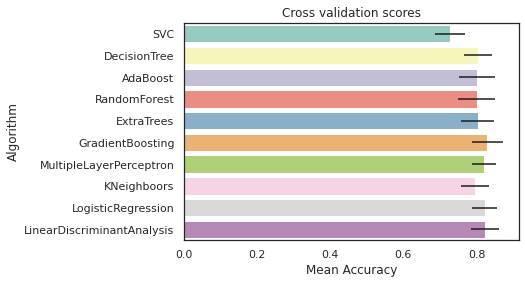

In [287]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: 변수가 동일선상에 있습니다.
   warnings.warn("변수는 동일선상에 있습니다.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: 변수가 동일선상에 있습니다.
   warnings.warn("변수는 동일선상에 있습니다.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: 변수가 동일선상에 있습니다.
   warnings.warn("변수는 동일선상에 있습니다.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: 변수가 동일선상에 있습니다.
   warnings.warn("변수는 동일선상에 있습니다.")

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 및 GradientBoosting 분류기를 선택하기로 결정했습니다.

#### 6.1.2 최고의 모델을 위한 하이퍼마라미터 튜닝

AdaBoost, ExtraTrees, RandomForest, GradientBoosting 및 SVC 분류기에 대한 그리드 검색 최적화를 수행했습니다.

cpu가 4개이므로 "n_jobs" 매개변수를 4로 설정했습니다. 계산 시간이 확실히 줄어듭니다.

하지만 주의하세요. 이 단계는 시간이 오래 걸릴 수 있습니다. 저는 4개의 CPU에서 총 15분이 걸렸습니다.

In [288]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [289]:
gsadaDTC.best_score_

0.8275536261491316

In [290]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320224719101124

In [291]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342568947906027

In [292]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8297242083758938

In [216]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 학습 곡선 그리기

학습 곡선은 훈련 세트에 대한 과적합 효과와 정확도에 대한 훈련 크기의 영향을 확인하는 좋은 방법입니다.

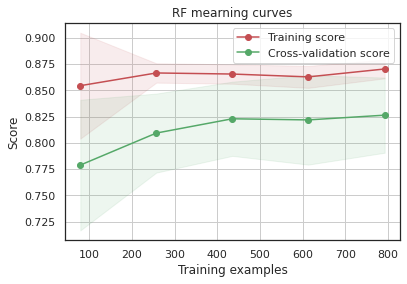

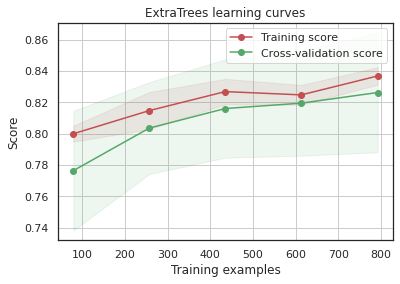

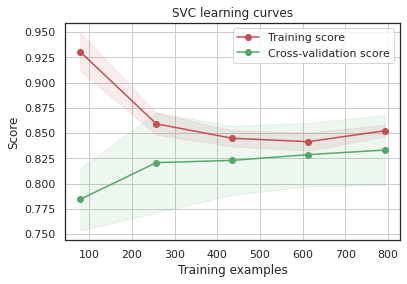

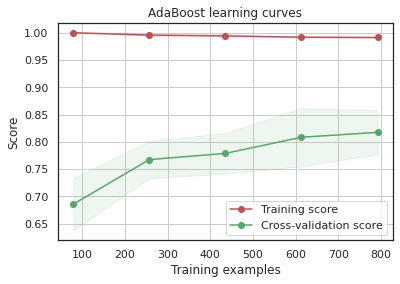

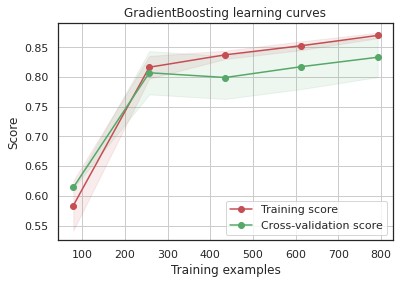

In [217]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting 및 Adaboost 분류기는 훈련 세트를 과적합하는 경향이 있습니다. 증가하는 교차 검증 곡선에 따르면 GradientBoosting과 Adaboost는 더 많은 훈련 예제를 통해 더 나은 성능을 보일 수 있습니다.

SVC 및 ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같습니다.

#### 6.1.4 트리 기반 분류기의 특성 중요도

승객 생존 예측을 위한 가장 유익한 특성을 보기 위해 4개의 트리 기반 분류기에 대한 특성 중요도를 표시했습니다.

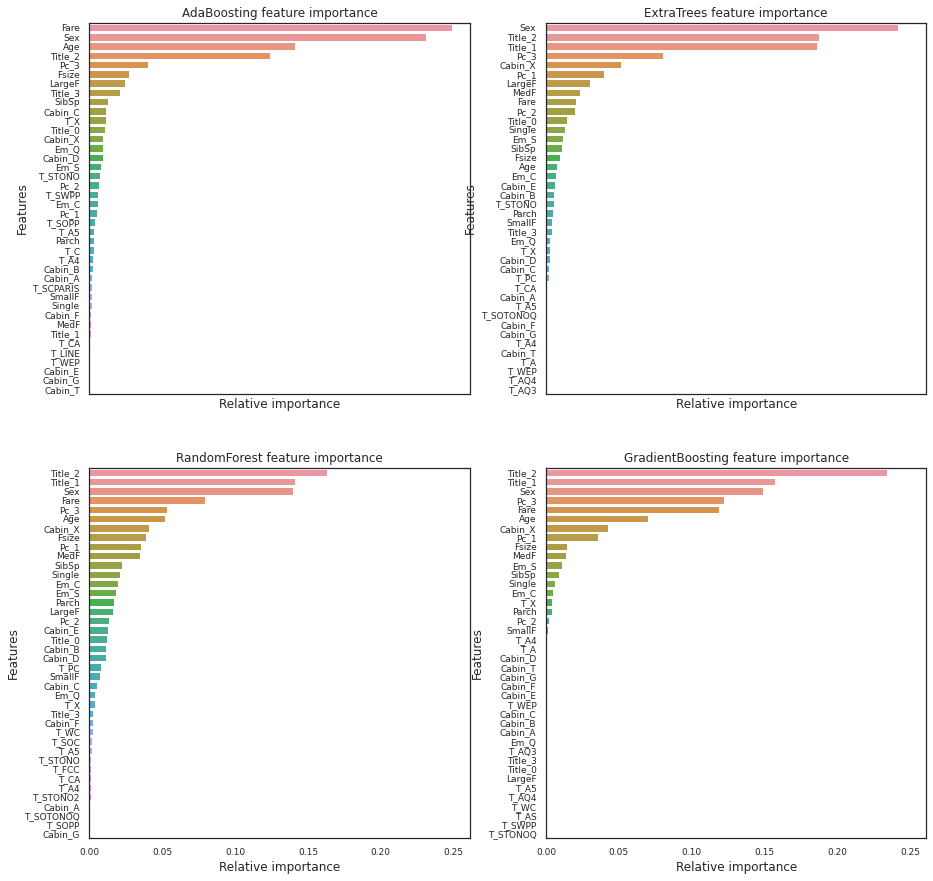

In [218]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

4가지 트리 기반 분류기(Adaboost, ExtraTrees, RandomForest 및 GradientBoosting)에 대한 기능 중요도를 표시합니다.

4개의 분류기는 상대적 중요도에 따라 서로 다른 상위 기능을 가집니다. 이는 그들의 예측이 동일한 기능을 기반으로 하지 않는다는 것을 의미합니다. 그럼에도 불구하고 'Fare', 'Title_2', 'Age' 및 'Sex'와 같이 분류에 대한 몇 가지 공통적인 중요한 기능을 공유합니다.

Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타내는 Title_2는 Sex와 높은 상관관계를 보입니다.

우리는 다음과 같이 말할 수 있습니다.

Pc_1, Pc_2, Pc_3 및 Fare는 승객의 일반적인 사회적 지위를 나타냅니다.

성별 및 Title_2(Mrs/Mlle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 나타냅니다.

Age 및 Title_1(마스터)은 승객의 나이를 나타냅니다.

Fsize, LargeF, MedF, Single은 승객 가족의 크기를 나타냅니다.

이 4개의 분류기의 특징 중요도에 따르면, 생존 예측은 배의 위치보다 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련이 있는 것으로 보입니다.

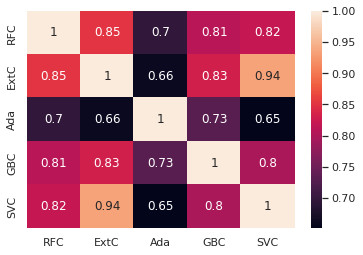

In [219]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

예측은 Adaboost가 다른 분류기와 비교할 때를 제외하고 5개의 분류기에 대해 매우 유사한 것으로 보입니다.

5개의 분류기는 거의 동일한 예측을 제공하지만 몇 가지 차이점이 있습니다. 5개의 분류기 예측 간의 이러한 차이는 앙상블 투표를 고려하기에 충분합니다.

### 6.2 앙상블 모델링

#### 6.2.1 모델 결합

저는 5개의 분류기에서 나오는 예측을 결합하기 위해 투표 분류기를 선택했습니다.

각 투표의 확률을 고려하기 위해 "soft" 인수를 투표 매개변수에 전달하는 것을 선호했습니다.

In [220]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 예측

#### 6.3.1 예측 과 결과 제출

In [221]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

이 노트북이 도움이 되거나 그냥 마음에 들었다면, 일부 찬성표를 주시면 대단히 감사하겠습니다. 그러면 계속 동기가 부여될 것입니다 :)